# <center> Poincarré Embeddings - Implementation </center>

In this notebook, we propose a pure Numpy implementation of the Poincarré embeddings method proposed by Maximilian Nickel and Douwe Kiela.

We use the WordNet dataset which enables to construct a hierarchical graph of words. The class <b>Poincarre_Embeddings</b> has the following methods :
- <i>create_embeddings</i> to create a hierarchical dataset
- <i>train</i> to perform the optimization process and plot the final result when setting dimension=2

In [1]:
# Packages import 

import numpy as np
from numpy.linalg import norm
from math import *
import matplotlib.pyplot as plt
import random
import nltk
nltk.download('wordnet')  
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlesdognin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## I. WordNet

<i>WordNet is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets). Synsets are interlinked by means of conceptual-semantic and lexical relations. [...] WordNet groups words together based on their meanings. [...] The main relation among words in WordNet is synonymy, as between the words shut and close or car and automobile. Synonyms--words that denote the same concept and are interchangeable in many contexts--are grouped into unordered sets (synsets).</i>

In [2]:
# Choose a source word for our graph, here the word "mammal", whose level in the graph is 0 (by default)

mammal = wordnet.synset("mammal.n.01")
print(mammal)
print('-------------------------')
print("The definition of mammal is :", mammal.definition())

Synset('mammal.n.01')
-------------------------
The definition of mammal is : any warm-blooded vertebrate having the skin more or less covered with hair; young are born alive except for the small subclass of monotremes and nourished with milk


#### Hyponyms
Hyponyms of a node, (i.e. a word in the graph) are the children of this node in the graph.

In [3]:
# Hyponyms of the source word, i.e. its direct children in the graph
mammal.hyponyms()

[Synset('female_mammal.n.01'),
 Synset('fossorial_mammal.n.01'),
 Synset('metatherian.n.01'),
 Synset('placental.n.01'),
 Synset('prototherian.n.01'),
 Synset('tusker.n.01')]

## II. Words embedding

First, we need to construct our dataset, which is done in the following way :
- We start from a word wordnet.synset("word")
- Then we construct a dictionary representing the graph that is linked to this word, i.e. <b>{"word" : [list of hyponyms]}</b>
- Then we construct a dictionary that contains the level of the words in the graph, i.e. <b>{"word" : level of word}</b>
- Finally, we also construct a dictionary that contains a mapping between a word and its embedding, i.e. <b>{"word" : embedded vector}</b>


Note that in the graph dictionary, a single word can be either key or value, whereas in the embeddings dictionary, each word is unique.

In [15]:
class Poincarre_Embeddings:
    
    def __init__(self, epochs, learning_rate, nb_negs, root_node, dimension):
        """
        Object providing the embedding for words related by hypernemy relations using 
        hyperbolic geometry.
        
        Arguments:
        epochs -- number of epochs/iterations
        learning_rate -- the learning rate for update of the embedding
        nb_negs -- number of negative samples
        root_node -- the higher word in the hierarchy, the format must be: wordnet.synset("word.n.01")
        dimension -- the embedding dimension
        """
        
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.nb_negs = nb_negs
        self.root_node = root_node
        self.dimension = dimension
        
    # Sample graph as a dictionnary

    def sample_graph(self, root_node, max_level=3) :
        """
        Function that samples a hierarchical network from a root node and its hyponyms.
        
        Arguments:
        root_node -- root node of the network
        max_level -- (int) maximum level of the network
        
        Returns:
        graph -- dictionnary representing the graph {"node" : [hyponyms]}
        levels -- dictionnary representing the level of each node {"node" : level}
        """

        levels, graph = {}, {}

        # keep track of visited nodes
        explored = []

        # keep track of nodes to be checked
        queue = [root_node]
        levels[str(root_node)] = 0
        visited = [str(root_node)]

        while queue:

            # take out first node from queue
            node = queue.pop(0)  # node n'est PAS un str

            # condition on maximum level
            if levels[str(node)] == max_level:
                graph[str(node)] = []
                break;

            # mark node as explored node
            explored.append(str(node))  # explored est un str

            # sample neighbours of node (i.e. its hyponyms)
            neighbours = [neighbour for neighbour in node.hyponyms()]  # ce sont pas des str
            neighbours_str = [str(neighbour) for neighbour in node.hyponyms()]

            # add neighbours to the graph (as children of the node)
            graph[str(node)] = neighbours_str

            # add neighbours of node to queue
            for neighbour in neighbours :   # no str
                if str(neighbour) not in visited :
                    queue.append(neighbour) # no str
                    visited.append(str(neighbour))
                    levels[str(neighbour)] = levels[str(node)] + 1

        return graph, levels
    
    def sample_embeddings(self, graph, dimension):
        """
        Initializes embedded vectors of graph.
        
        Arguments:
        graph -- graph containing words
        dimension -- (int) dimension of the embedding space
        
        Returns:
        embeddings -- dictionnary of the form {"node" : vector}
        """

        embeddings = {}

        for word in graph:
            embeddings[word] = np.random.uniform(low=-0.1, high=0.1, size=(dimension,))

        return embeddings
    
    def create_embeddings(self, dimension, root_node):
        """
        Creates embeddings for words
        
        Arguments: 
        dimension -- (int) dimension of the embedding space
        root_node -- root node of the network
        
        Returns:
        graph -- dictionnary representing the graph {"node" : [hyponyms]}
        embeddings -- dictionnary of the form {"node" : vector}
        """
        
        graph, levels = self.sample_graph(self.root_node) 
        embeddings = self.sample_embeddings(graph, self.dimension)
        
        return graph, embeddings
        

    def dist(self, u, v):
        """
        Computes the distance for the Poincaré disk model between two vectors u and v

        Arguments:
        u -- first embedded object
        v -- second embedded object

        Returns:
        z -- the ditance between the two objects
        """

        norm2u = norm(u)**2
        norm2v = norm(u)**2
        norm2distuv = norm(u - v)**2
        t = 1 + 2 * (norm2distuv / ((1 - norm2u) * (1 - norm2v)))
        z = np.arccosh(t)
        
        return z

    def pdr(self, theta, x):
        """
        Computes the partial derivative w.r.t theta

        Arguments:
        theta -- embedding of the object
        x -- vector corresponding to the embedding of another object (same dimension as theta)

        Returns:
        partial -- the derivative (same dimension as theta)  
        """

        alpha = 1.0 - norm(theta)**2
        assert len(alpha.shape) == 0
        beta = 1.0 - norm(x)**2
        assert len(beta.shape) == 0
        gamma = 1 + (2 / (alpha * beta)) * norm(alpha - x)**2
        assert len(gamma.shape) == 0
        assert gamma**2 - 1 >= 0
        partial = 4.0 / (beta * np.sqrt(gamma**2 - 1)) * (((norm(x) - 2 * np.dot(theta, x) + 1) / alpha**2) * theta - (x / alpha))

        return partial

    def proj(self, theta, epsilon=1e-5):
        """
        Projection in the Poincaré disk ball

        Parameters:
        theta --  embedding of the object
        epsilon -- scalar (for stability)

        Returns:
        theta -- after projection
        """

        if norm(theta) >= 1:
            theta = (theta / norm(theta)) - epsilon

        return theta

    def update(self, theta, grad, learning_rate):
        """
        Computes the full update for a single embedding of theta

        Parameters:
        theta -- current embedding of the object
        grad -- gradient of the loss function 
        learning_rate -- the learning rate 

        Returns:
        theta -- the updated theta
        """

        upd = (learning_rate / 4) * (1 - norm(theta)**2)**2 * grad
        theta = self.proj(theta - upd)
        assert theta.shape == upd.shape

        return theta
    
    def loss(self, u, v, negative_samples):
        """
        Computes the loss for a single couple of related nodes (u,v)

        Arguments:
        u -- embedding of one object
        v -- embedding of one object
        negative_samples -- set of negative samples for u including v

        Returns:
        loss -- the value of the loss
        """
        
        negative_distances = [np.exp(-self.dist(u, k)) for k in negative_samples]
        loss = -self.dist(u, v) - np.log(np.sum(negative_distances))

        return loss 
    
    def pdl(self, u, negative_samples):
        """
        Computes the partial derivative of the loss w.r.t d(u,v), d(u,v'), where v' is a negative example for u
        
        Arguments:
        u -- embedding of one object
        negative_samples -- list of negative samples for u
        positive -- boolean, computes the partial derivative of the loss w.r.t d(u,v) if True
        
        Returns:
        derivative -- the partial derivative (scalar or list)
        """
    
        negative_distances = [np.exp(-self.dist(u, k)) for k in negative_samples]
        derivative = [np.exp(self.dist(u, k)) / np.sum(negative_distances) for k in negative_samples]

        return derivative 
    
    def clean_word(self, word):
        """
        Word cleaning tool 
        """
        word = str(word).strip("Synset")
        word = word.strip("(")
        word = word.strip(")")
        word = word.strip("'")
        word = word.strip(".n.01")
        
        return word
    
    def plot_(self, embeddings):
        """
        Function that allows to plot the embedded vectors when the embedding space is 2 dimensional
        """        
        fig, ax = plt.subplots();
         
        for word in embeddings.keys():#np.random.choice(list(embeddings.keys()), 100):
            ax.scatter(embeddings[word][0], embeddings[word][1])
            ax.annotate(self.clean_word(word), (embeddings[word][0], embeddings[word][1]))
        ax.scatter(embeddings["Synset('mammal.n.01')"][0], embeddings["Synset('mammal.n.01')"][1])
        ax.annotate(self.clean_word("Synset('mammal.n.01')"), (embeddings["Synset('mammal.n.01')"][0], embeddings["Synset('mammal.n.01')"][1]))
        plt.show();

    def train(self):
        """
        Train the embedding with gradient descent
        
        Returns:
        embeddings -- the learnt and optimized embeddings
        """
        
        graph, embeddings = self.create_embeddings(self.dimension, self.root_node)
        embeddings_temp = embeddings.copy()
        
        ## Select couple (u, v) and negative samples for u
        for u in embeddings_temp:
            if len(graph[u]) == 0:
                continue
            
            # if v is a child node but is not in the embeddings dictionary, add it
            for v in graph[u]:
                if v not in graph.keys():
                    graph[v] = []
                    embeddings[v] = np.random.uniform(low=-0.1, high=0.1, size=(self.dimension,))
                
        for epoch in range(self.epochs):
            #if epoch % 100 == 0:
             #   print(epoch)
            # Select word
            for u in embeddings:
                if len(graph[u]) == 0:
                    continue
                    
                # Select v among the hyponyms of u
                v = np.random.choice(graph[u])
            
                # Select negative examples for u
                negative_samples, negative_samples_words = [], []  # list of vectors/list of words
                
                while len(negative_samples) < self.nb_negs:

                    # draw sample randomly from data
                    negative_sample = np.random.choice(list(embeddings.keys()))

                    # if the drawn sample is connected to u, discard it
                    if negative_sample in graph[u] or u in graph[negative_sample] or negative_sample == u:
                        continue 

                    negative_samples_words.append(negative_sample)
                    negative_sample = embeddings[negative_sample]
                    negative_samples.append(negative_sample)


                ## Compute the individual loss
                loss = self.loss(embeddings[u], embeddings[v], negative_samples)

                ## Compute the partial derivatives of the loss with respect to u, v and the negative examples

                # derivative of loss with respect to u
                grad_u = -1.0 * self.pdr(embeddings[u], embeddings[v])

                # derivative of loss with respect to v
                grad_v = -1.0 * self.pdr(embeddings[v], embeddings[u])

                # derivative of loss with respect to the negative examples
                grad_negatives = []
                grad_negatives_temp = self.pdl(embeddings[u], negative_samples)

                for (negative_sample, grad_negative) in zip(negative_samples, grad_negatives_temp):
                    gradient = grad_negative * self.pdr(negative_sample, embeddings[u])
                    grad_negatives.append(gradient)

                ## Update embeddings

                # update u
                embeddings[u] = self.update(embeddings[u], grad_u, self.learning_rate)

                # update v
                embeddings[v] = self.update(embeddings[v], grad_v, self.learning_rate)

                # update negative samples
                for (negative_sample, grad_negative, negative_sample_word) in zip(negative_samples, grad_negatives, negative_samples_words):
                        embeddings[negative_sample_word] = self.update(negative_sample, grad_negative, self.learning_rate)
        self.plot_(embeddings)                           
        return embeddings        

## III. Examples

We select the root node "mammal".

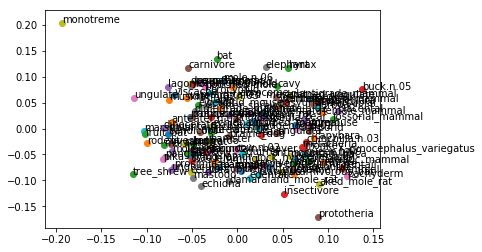

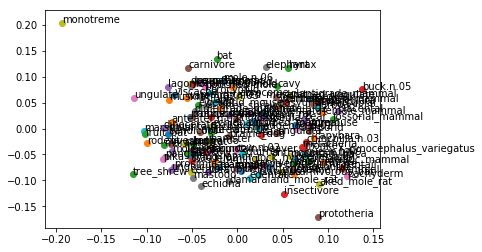

In [16]:
mammal = wordnet.synset("mammal.n.01")
cls = Poincarre_Embeddings(200, 0.01, 4, mammal, 2)
embeddings = cls.train()
cls.plot_(embeddings)